In this notebook, we will generate mock data for the DESY3, KiDS-1000 and HSCDR1 weak lensing samples.

The input power spectra comes from EuclidEmulator2 and the baryon parameters mimic BAHAMAS.

In this notebook we want to explore the impact of using baccoemu which predicts the Pk up to k<5 h/Mpc. We will not use baryons but generate the matter Pk with EE2 up to k<10 h/Mpc

In [1]:
import numpy as np
import pyccl as ccl
import sacc
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
import scipy

In [2]:
s = sacc.Sacc.load_fits('/mnt/extraspace/davidjamiecarlos/xCell_run1_shear_baryons/cls_DESY3_noK1000_noHSCDR1wl_plus_KiDS1000_noHSCDR1wl_cov_4096_GNG.fits') # Load the SACC file
s.keep_selection(data_type='cl_ee')

In [2]:
# Load the power spectrum
pk = {}
pkfile = np.load('./BlindCarlosPk.npz', allow_pickle=True)
pk['5kmax'] = ccl.Pk2D(a_arr=pkfile['expfactors'], lk_arr=np.log(pkfile['k [1/Mpc]']), pk_arr=np.log(pkfile['Pk GrO [Mpc]^3']), is_logp=True)

pkfile = np.load('./EE2kmax10.npz', allow_pickle=True)
pk['10kmax'] = ccl.Pk2D(a_arr=pkfile['expfactors'], lk_arr=np.log(pkfile['k [1/Mpc]']), pk_arr=np.log(pkfile['Pk GrO [Mpc]^3']), is_logp=True)

cosmopars = dict(pkfile['cosmopars'].tolist())
cosmopars.update({'sigma8_tot': float(pkfile['sigma8 tot'])})
cosmopars['omega_matter'] = cosmopars['omega_cold'] + cosmopars['neutrino_mass'] / 93.14 / cosmopars['hubble']**2

# Initiate CCL Cosmology
cosmo = ccl.Cosmology(Omega_c=cosmopars['omega_cold'] - cosmopars['omega_baryon'], Omega_b=cosmopars['omega_baryon'],
                      h=cosmopars['hubble'], sigma8=cosmopars['sigma8_tot'], n_s=cosmopars['ns'], m_nu=cosmopars['neutrino_mass'])
ccl.sigma8(cosmo)

cosmopars

/mnt/zfsusers/gravityls_3/mambaforge/envs/baryons/lib/python3.9/site-packages/pyccl/core.py:745: CCLWarning: CCL does not properly compute the linear growth rate in cosmological models with massive neutrinos!
  warnings.warn(


{'omega_cold': 0.31,
 'omega_baryon': 0.045,
 'sigma8_cold': 0.82,
 'ns': 0.965,
 'hubble': 0.7,
 'neutrino_mass': 0.06,
 'w0': -1,
 'wa': 0,
 'M_c': 13.58,
 'eta': -0.27,
 'beta': -0.33,
 'M1_z0_cen': 12.04,
 'theta_out': 0.25,
 'theta_inn': -0.86,
 'M_inn': 13.4,
 'sigma8_tot': 0.8163992592396454,
 'omega_matter': 0.31131467661146484}

In [3]:
k = np.logspace(-3, 2, 1000)

f, ax = plt.subplots(2, 1, gridspec_kw={'hspace': 0., 'wspace': 0.}, sharex=True)

ax[0].loglog(k, pk['5kmax'](k, 1.0, cosmo), label='5 kmax')
ax[0].loglog(k, pk['10kmax'](k, 1.0, cosmo), label='10 kmax')

# reldev
ax[1].semilogx(k, pk['10kmax'](k, 1.0, cosmo) / pk['5kmax'](k, 1.0, cosmo) -1)

for i in range(2):
    ax[i].axvline(5 * cosmopars['hubble'], ls='--', color='blue')
    ax[i].axvline(10 * cosmopars['hubble'], ls=':', color='orange')
    
ax[1].set_xlabel('k [1/Mpc]')
ax[0].set_ylabel('P(k) [Mpc^3]')
ax[1].set_ylabel('rel. dev.')
ax[0].legend()
plt.show()
plt.close()

In [5]:
# Generate the angular power spectra
# Redshift shifts
dz_shifts = {'DESY3wl__0': 0,
             'DESY3wl__1': 0,
             'DESY3wl__2': 0, 
             'DESY3wl__3': 0,
             'KiDS1000__0': 0,
             'KiDS1000__1': -0.002,
             'KiDS1000__2': -0.013,
             'KiDS1000__3': -0.011,
             'KiDS1000__4': 0.006,
             'HSCDR1wl__0': 0,
             'HSCDR1wl__1': 0,
             'HSCDR1wl__2': 0,
             'HSCDR1wl__3': 0}

# Multiplicative bias
m_wl = {'DESY3wl__0': -0.0063,
         'DESY3wl__1': -0.0198,
         'DESY3wl__2': -0.0241, 
         'DESY3wl__3': -0.0369,
         'KiDS1000__0': 0,
         'KiDS1000__1': 0.,
         'KiDS1000__2': 0.,
         'KiDS1000__3': 0.,
         'KiDS1000__4': 0.,
         'HSCDR1wl__0': 0,
         'HSCDR1wl__1': 0,
         'HSCDR1wl__2': 0,
         'HSCDR1wl__3': 0}

# Instatiate the ccl tracers
ccl_tracers = {}
z = np.linspace(0, 4, 100)

for trn, trv in s.tracers.items():
    dndz = interp1d(trv.z, trv.nz, bounds_error=False, fill_value=0) # Interpolate the dndz
    ccl_tracers[trn] = ccl.WeakLensingTracer(cosmo, dndz=(z, dndz(z - dz_shifts[trn])), has_shear=True, ia_bias=None)
    
smock_nn = {}
for kmax in ['5kmax', '10kmax']:
    print(f'Computing angular power spectrum for pk with kmax = {kmax}')
    # Compute the angular power spectrum
    clmock = {}
    clmock_mean = np.zeros_like(s.mean)
    for trs in s.get_tracer_combinations():
        ix = s.indices(tracers=trs)
        bpw = s.get_bandpower_windows(ix)
        l_bpw = bpw.values
        w_bpw = bpw.weight.T

        cl = ccl.angular_cl(cosmo, ccl_tracers[trs[0]], ccl_tracers[trs[1]], l_bpw, p_of_k_a=pk[kmax])
        clbin = w_bpw.dot(cl)
        clfinal = (1+m_wl[trs[0]]) * (1 + m_wl[trs[1]]) * clbin

        clmock[trs] = clfinal
        clmock_mean[ix] = clfinal

    # Create sacc file with these clmocks
    smock_nn[kmax] = s.copy()
    smock_nn[kmax].mean = clmock_mean

/mnt/zfsusers/gravityls_3/mambaforge/envs/baryons/lib/python3.9/site-packages/pyccl/tracers.py:110: CCLWarning: The number of samples in the n(z) (100) is smaller than the number of samples in the lensing kernel (256). Consider disabling spline integration for the lensing kernel by setting pyccl.gsl_params.LENSING_KERNEL_SPLINE_INTEGRATION = False
  warnings.warn(


Computing angular power spectrum for pk with kmax = 5kmax
Computing angular power spectrum for pk with kmax = 10kmax


In [6]:
# for kmax in ['5kmax', '10kmax']:
#     smock_nn[kmax].save_fits(f'./cls_DESY3_noK1000_noHSCDR1wl_plus_KiDS1000_noHSCDR1wl_cov_4096_GNG_mockEuclidEmulator2_GrO_{kmax}_noiseless.fits')

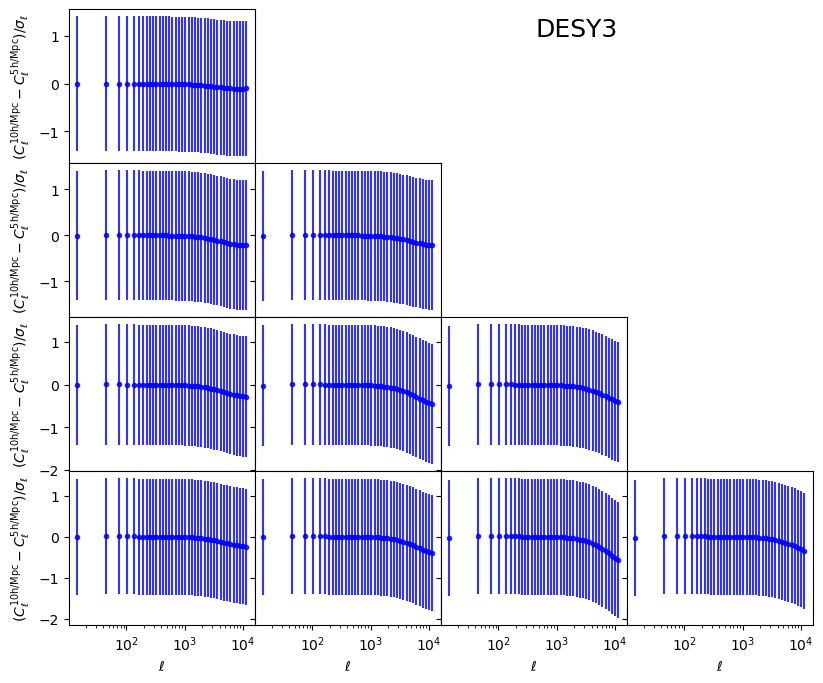

In [7]:
survey = 'DESY3'
nbin = 4


f, ax = plt.subplots(nbin, nbin, figsize=(9.6, 8), sharex='col', sharey='row', gridspec_kw={'hspace':0, 'wspace':0})
for trs in s.get_tracer_combinations():
    if survey not in ''.join(trs):
        continue
    i = int(trs[1].split('__')[1])
    j = int(trs[0].split('__')[1])
 
    # Mock
    ell, cl10kmax, cov = smock_nn['10kmax'].get_ell_cl('cl_ee', trs[0], trs[1], return_cov=True)
    ell, cl5kmax, cov = smock_nn['5kmax'].get_ell_cl('cl_ee', trs[0], trs[1], return_cov=True)
    err = np.sqrt(np.diag(cov))
    ax[i, j].errorbar(ell, (cl10kmax - cl5kmax) / err, yerr=np.sqrt(2), fmt='.', color='blue', label='Mock', alpha=0.8)   

    if i != j:
        ax[j, i].axis('off')

for i in range(nbin):
    ax[i, 0].set_ylabel(r"$(C_\ell^{\rm 10 h/Mpc} - C_\ell^{\rm 5 h/Mpc}) / \sigma_\ell$")
    ax[-1, i].set_xlabel("$\ell$")
    ax[0, i].set_xscale("log")

t = ax[0, 2].text(0.95, 0.95, f'{survey}', horizontalalignment='right',
                  verticalalignment='top', transform=ax[0, 2].transAxes, fontsize=18) 
# ax[0, 0].legend(bbox_to_anchor=(1., 1.05))


plt.show()
plt.close()

In [8]:
survey = 'KiDS1000'
nbin = 5


f, ax = plt.subplots(nbin, nbin, figsize=(12, 12), sharex='col', sharey='row', gridspec_kw={'hspace':0, 'wspace':0})
for trs in s.get_tracer_combinations():
    if survey not in ''.join(trs):
        continue
    i = int(trs[1].split('__')[1])
    j = int(trs[0].split('__')[1])

    # Mock
    ell, cl10kmax, cov = smock_nn['10kmax'].get_ell_cl('cl_ee', trs[0], trs[1], return_cov=True)
    ell, cl5kmax, cov = smock_nn['5kmax'].get_ell_cl('cl_ee', trs[0], trs[1], return_cov=True)
    err = np.sqrt(np.diag(cov))
    ax[i, j].errorbar(ell, (cl10kmax - cl5kmax) / err, yerr=np.sqrt(2), fmt='.', color='blue', label='Mock', alpha=0.8)  
    
    if i != j:
        ax[j, i].axis('off')

for i in range(nbin):
    ax[i, 0].set_ylabel(r"$(C_\ell^{\rm 10 h/Mpc} - C_\ell^{\rm 5 h/Mpc}) / \sigma_\ell$")
    ax[-1, i].set_xlabel("$\ell$")
    ax[0, i].set_xscale("log")

t = ax[0, 2].text(0.95, 0.95, f'{survey}', horizontalalignment='right',
                  verticalalignment='top', transform=ax[0, 2].transAxes, fontsize=18) 


plt.show()
plt.close()

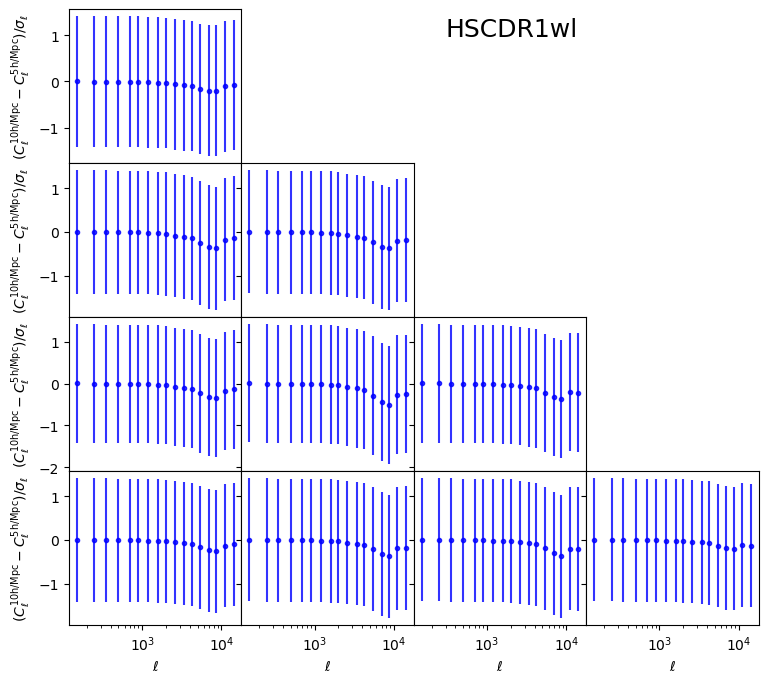

In [9]:
survey = 'HSCDR1wl'
nbin = 4


f, ax = plt.subplots(nbin, nbin, figsize=(8.9, 8), sharex='col', sharey='row', gridspec_kw={'hspace':0, 'wspace':0})
for trs in s.get_tracer_combinations():
    if survey not in ''.join(trs):
        continue
    i = int(trs[1].split('__')[1])
    j = int(trs[0].split('__')[1])

    # Mock
    ell, cl10kmax, cov = smock_nn['10kmax'].get_ell_cl('cl_ee', trs[0], trs[1], return_cov=True)
    ell, cl5kmax, cov = smock_nn['5kmax'].get_ell_cl('cl_ee', trs[0], trs[1], return_cov=True)
    err = np.sqrt(np.diag(cov))
    ax[i, j].errorbar(ell, (cl10kmax - cl5kmax) / err, yerr=np.sqrt(2), fmt='.', color='blue', label='Mock', alpha=0.8)  

    if i != j:
        ax[j, i].axis('off')

for i in range(nbin):
    ax[i, 0].set_ylabel(r"$(C_\ell^{\rm 10 h/Mpc} - C_\ell^{\rm 5 h/Mpc}) / \sigma_\ell$")
    ax[-1, i].set_xlabel("$\ell$")
    ax[0, i].set_xscale("log")

t = ax[0, 2].text(0.95, 0.95, f'{survey}', horizontalalignment='right',
                  verticalalignment='top', transform=ax[0, 2].transAxes, fontsize=18) 


plt.show()
plt.close()

In [10]:
s = {'data': s}
for kmax in ['5kmax', '10kmax']:
    s[kmax] =  smock_nn[kmax]

In [11]:
survey = 'DESY3'
nbin = 4

f, ax = plt.subplots(nbin, nbin, figsize=(9.6, 8), sharex='col', sharey='row', gridspec_kw={'hspace':0, 'wspace':0})
for trs in s['data'].get_tracer_combinations():
    if survey not in ''.join(trs):
        continue
    i = int(trs[1].split('__')[1])
    j = int(trs[0].split('__')[1])

    # Data
    for case, color in zip(['data', '5kmax', '10kmax'],  ['k', 'r', 'b']):
        ell, cl, cov, ind = s[case].get_ell_cl('cl_ee', trs[0], trs[1], return_cov=True, return_ind=True)
        err = np.sqrt(np.diag(cov))
        ax[i, j].errorbar(ell, ell * cl * 1e7, yerr=ell*err * 1e7, fmt='.', color=color, label=case, alpha=0.8)

    if i != j:
        ax[j, i].axis('off')

for i in range(nbin):
    ax[i, 0].set_ylabel("$\ell C_\ell (10^{-7})$")
    ax[-1, i].set_xlabel("$\ell$")
    ax[0, i].set_xscale("log")

t = ax[0, 2].text(0.95, 0.95, f'{survey}', horizontalalignment='right',
                  verticalalignment='top', transform=ax[0, 2].transAxes, fontsize=18) 
ax[0, 0].legend(bbox_to_anchor=(1., 1.05))


plt.show()
plt.close()

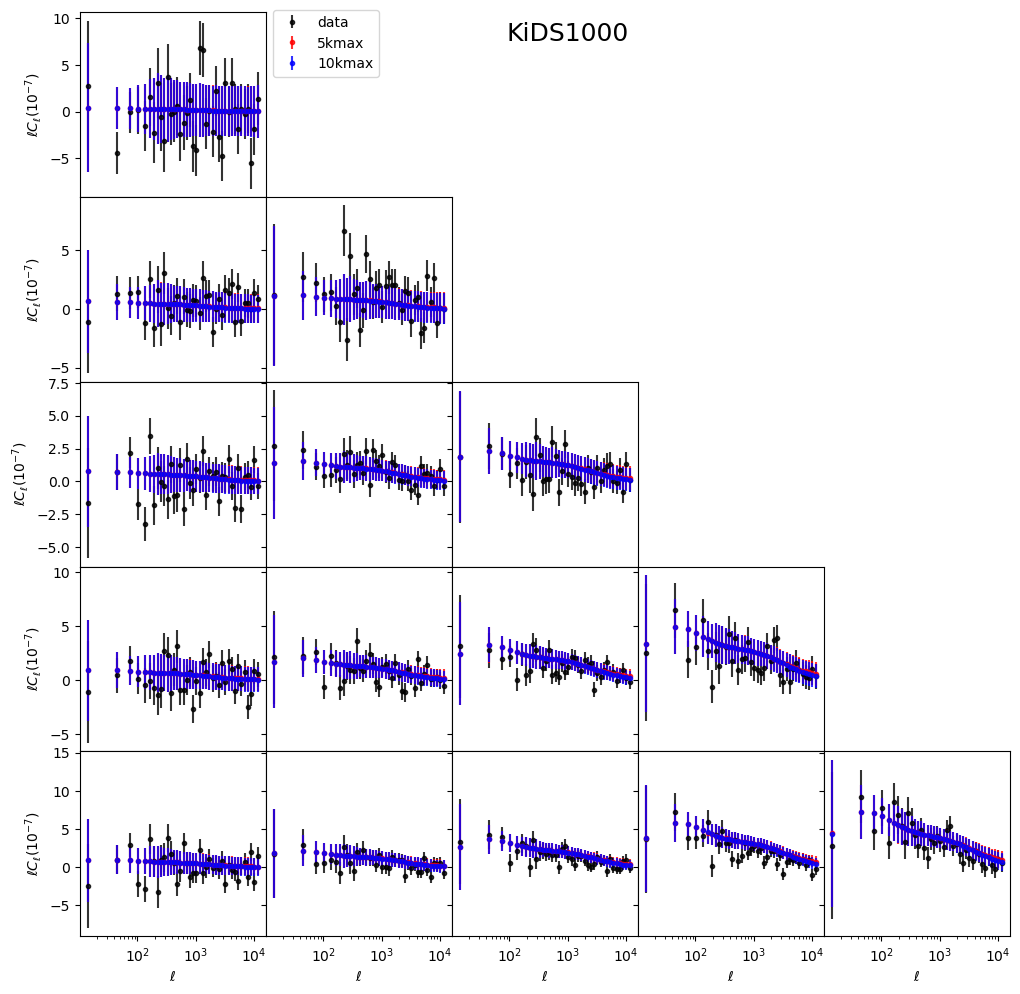

In [14]:
survey = 'KiDS1000'
nbin = 5


f, ax = plt.subplots(nbin, nbin, figsize=(12, 12), sharex='col', sharey='row', gridspec_kw={'hspace':0, 'wspace':0})
for trs in s['data'].get_tracer_combinations():
    if survey not in ''.join(trs):
        continue
    i = int(trs[1].split('__')[1])
    j = int(trs[0].split('__')[1])

    # Data
    for case, color in zip(['data', '5kmax', '10kmax'],  ['k', 'r', 'b']):
        ell, cl, cov, ind = s[case].get_ell_cl('cl_ee', trs[0], trs[1], return_cov=True, return_ind=True)
        err = np.sqrt(np.diag(cov))
        ax[i, j].errorbar(ell, ell * cl * 1e7, yerr=ell*err * 1e7, fmt='.', color=color, label=case, alpha=0.8)

    if i != j:
        ax[j, i].axis('off')

for i in range(nbin):
    ax[i, 0].set_ylabel("$\ell C_\ell (10^{-7})$")
    ax[-1, i].set_xlabel("$\ell$")
    ax[0, i].set_xscale("log")

t = ax[0, 2].text(0.95, 0.95, f'{survey}', horizontalalignment='right',
                  verticalalignment='top', transform=ax[0, 2].transAxes, fontsize=18) 
ax[0, 0].legend(bbox_to_anchor=(1., 1.05))


plt.show()
plt.close()

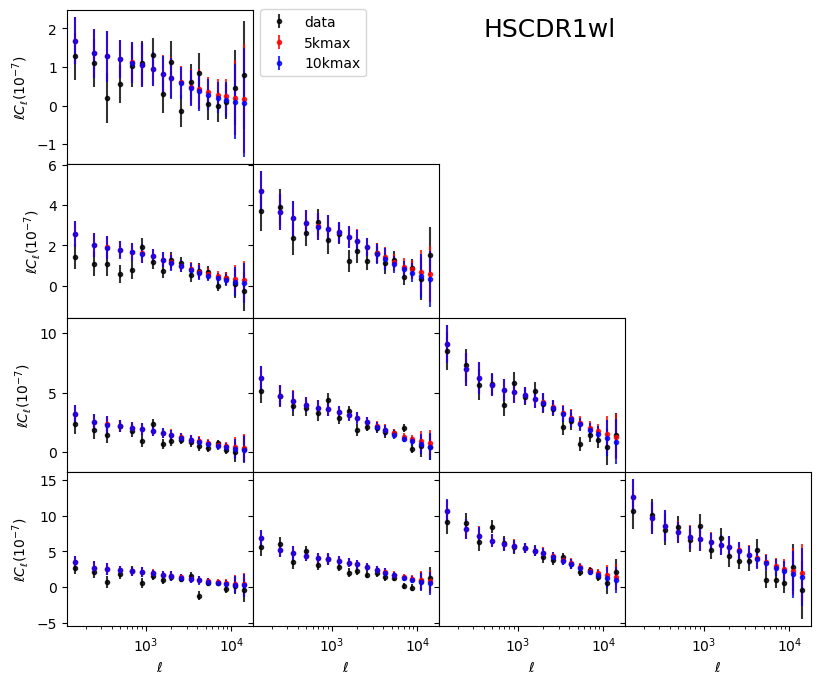

In [13]:
survey = 'HSCDR1wl'
nbin = 4


f, ax = plt.subplots(nbin, nbin, figsize=(9.6, 8), sharex='col', sharey='row', gridspec_kw={'hspace':0, 'wspace':0})
for trs in s['data'].get_tracer_combinations():
    if survey not in ''.join(trs):
        continue
    i = int(trs[1].split('__')[1])
    j = int(trs[0].split('__')[1])

    # Data
    for case, color in zip(['data', '5kmax', '10kmax'],  ['k', 'r', 'b']):
        ell, cl, cov, ind = s[case].get_ell_cl('cl_ee', trs[0], trs[1], return_cov=True, return_ind=True)
        err = np.sqrt(np.diag(cov))
        ax[i, j].errorbar(ell, ell * cl * 1e7, yerr=ell*err * 1e7, fmt='.', color=color, label=case, alpha=0.8)

    if i != j:
        ax[j, i].axis('off')

for i in range(nbin):
    ax[i, 0].set_ylabel("$\ell C_\ell (10^{-7})$")
    ax[-1, i].set_xlabel("$\ell$")
    ax[0, i].set_xscale("log")

t = ax[0, 2].text(0.95, 0.95, f'{survey}', horizontalalignment='right',
                  verticalalignment='top', transform=ax[0, 2].transAxes, fontsize=18) 
ax[0, 0].legend(bbox_to_anchor=(1., 1.05))


plt.show()
plt.close()